# Mini-lab 10 - SF Taxi data part 2

In last week's minilab we saw how we could use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to predict taxi fare data. This week we will take the analysis a bit deeper.

As a reminder, the dataset is San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip we are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz and arrival taz. 

In [ ]:
from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
sf_taxi = Table.read_table('../minilab9/SF_taxi_data.csv')
sf_taxi

# Part 1 (from mini-lab 9)
## Adding meaningful columns to our data table
The data table is rich, but the inputs are not as useful as they could be. For example we have date/time strings for arrival and departure. We may like to have information on trip duration, rather than a list of start and end times.

### Computing Trip Duration
We can write our own methods to help process the data. For example we can create a method to compute trip duration. First we have to convert the departure time and arrival time into a timestamp, then we can compute the difference. Finally we convert it to minutes. I have written the get_dur() function below.

Use the [.apply](http://data8.org/datascience/_autosummary/datascience.tables.Table.apply.html#datascience.tables.Table.apply) method to create a 'duration (min)' column, a trip 'start hour' column, a trip 'date' column, and a trip 'day of week' column in the sf_taxi table.

In [ ]:
def get_hour(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_date(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()

def get_dur(start,finish): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

In [ ]:
# Answer key
sf_taxi["duration (min)"] = sf_taxi.apply(lambda start, finish: get_dur(start, finish), ["departure time", "arrival time"])
sf_taxi['start hour'] = sf_taxi.apply(get_hour, "departure time")
sf_taxi['date'] = sf_taxi.apply(get_date, "departure time")
sf_taxi['day of week'] = sf_taxi.apply(get_weekday, "departure time")

## Trip fares exploration
SFMTA fare calculation table states that the fare for a trip of x miles will be at least 3.5 + 0.55 * (5x-1). Let us first explore the fare variable by plotting a histogram, and let's create a function to compute this base fare.

In [5]:
def base_fare(d):
    # 3.5 + 0.55*(5*d - 1), considering only completed 1/5-th miles (hence np.modf()[1])
    return ( 3.5 + 0.55* (np.modf(5*d)[1] - 1) )

# the histogram of trip fares
sf_taxi.select('fare ($)').hist(bins=np.arange(0,10,0.275))

### Most popular taxi trips
Turns out the TAZ that contains SFO is the TAZ that generates the most trips. 

In the cell below, find the most popular "deptaz" from the sf_taxi data - save the taz id as sfo_taz. The data science [group](http://data8.org/datascience/_autosummary/datascience.tables.Table.group.html?highlight=group) funtion might be helpful for this taks.

In [6]:
# Your code here:
# Answer key:
taz_counts = sf_taxi.group("deptaz")
print(taz_counts.where("count", max(taz_counts["count"])))
sfo_taz = taz_counts.where("count", max(taz_counts["count"]))["deptaz"][0]
taz_counts

deptaz | count
239    | 3696


deptaz,count
0,1210
1,1009
2,998
3,190
4,431
5,1267
6,789
7,2072
8,1051
9,758


### Visualize fares data
We are going to explore the dependence between the fare variable for the single-pax trips and the distance travelled. We will see how the actual fare paid relate to the base fare computed with a formula. Finally, we will highlight the trips from/to SFO with a different color. 

* Get trips where the number of passengers == 1 and remove fares <3.5, since base fare=3.5, these are likely to be errors. Save the result as sf_taxi. i.e. save over the previous table.
* Create a table called sfo where the deptaz or arrtaz is equal to the sfo_taz
* On the same scatter plot that has all trips, plot fares for trips from SFO in blue.

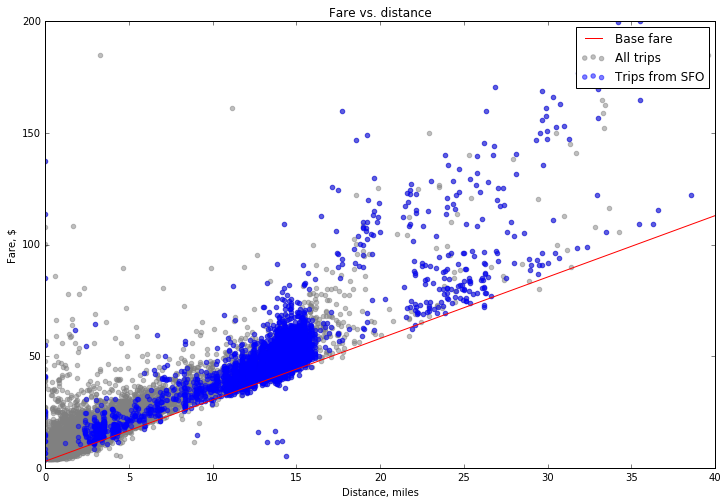

In [7]:
# Task 3 - your code here:

#Answer key:
sf_taxi = sf_taxi.where(sf_taxi["num"]==1)
sf_taxi = sf_taxi.where(sf_taxi["fare ($)"]>3.5)

#Create a scatter plot of the results:
plt.figure(figsize = (12,8))

# plot fares for all trips
x, y =  sf_taxi.column("dist (miles)"), sf_taxi.column("fare ($)")
plt.scatter(x,y,color='grey', alpha =.5, label='All trips')


# Task 4 - your code here:
# Answer key:
sfo = sf_taxi.where((sf_taxi.column("deptaz")==sfo_taz)|
                    (sf_taxi.column("arrtaz")==sfo_taz))


# Task 5 - your code here:
#Answer key:
x, y =  sfo.column("dist (miles)"), sfo.column("fare ($)")
plt.scatter(x,y,color='blue', alpha = .5, label='Trips from SFO')


# plot the lower bound of the fare, i.e. the official formula
plt.plot([0, 40], [base_fare(0), base_fare(40)], 'red', label='Base fare')

plt.title('Fare vs. distance')
plt.xlabel('Distance, miles')
plt.ylabel('Fare, $')
plt.ylim([0,200])
plt.xlim([0,40])
plt.legend()

## Non-SFO trips within 15 miles

Let us narrow it down to the non-SFO trips of 0.1<d<15 miles.
* Create a table called nsfo_taxi that contains all trips where "deptaz" and "arrtaz" are not equal to sfo_taz. Keep only the rows where 0.01<"dist (miles)"<15

In [8]:
# Your code here:
#Answer key
nsfo_taxi = sf_taxi.where((sf_taxi["deptaz"]!=sfo_taz) & (sf_taxi["arrtaz"]!=sfo_taz))
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] < 15)
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] > 0.1)

## Extra fare
In most trips, the actual fare was way higher than the base one. The reason for the extra fare paid by pax is traffic delays (and also drivers taking longer trips than necessary, sometimes due to congestion). Let's see if this extra surcharge is related to the length and duration of the trip. This will help us predict it before a trip started.

In [9]:
# Compute an extra fare paid by passengers
nsfo_taxi["extra"] = nsfo_taxi["fare ($)"] - base_fare(nsfo_taxi["dist (miles)"])


## Linear regression:
The functions below are introduced in data8 'correlation' and 'prediction' topics. See examples in http://data8.org/fa16/lectures/lec29.pdf

In [10]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    "Compute r."
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def predict(x, slope, intercept):
    y = x*slope+intercept
    return y

## Using the linear regression equations
In the cell below: 

* Find the slope of regression line that correspond to the "extra" cost (y) as a function of "dist (miles)", (x).
* Find the intercept of regression line that relates the "extra" cost (y) as a function of "dist (miles)", (x).
* Predict the 'extra' cost (above the base fare) for a 5 mile trip

In [11]:
# Your code here:

#answer key
extra_dist_slope = slope(nsfo_taxi,'dist (miles)','extra')
extra_dist_intercept = intercept(nsfo_taxi,'dist (miles)','extra')
extra_dist_5mi = predict(5,extra_dist_slope, extra_dist_intercept)
print ('The equation for the best fit regression line is: Extra = %.2f * dist + %.2f'
       %(extra_dist_slope, extra_dist_intercept))
print ('The expected extra cost for a 5 mile trip is $%.2f' %extra_dist_5mi)

The equation for the best fit regression line is: Extra = 0.77 * dist + 2.16
The expected extra cost for a 5 mile trip is $6.01


### Extra Fare vs Trip Length
In the cell below, we construct a scatter plot of the travel distance vs. extra cost (above the base fare). We overlay the best-fit regression line on the plot.

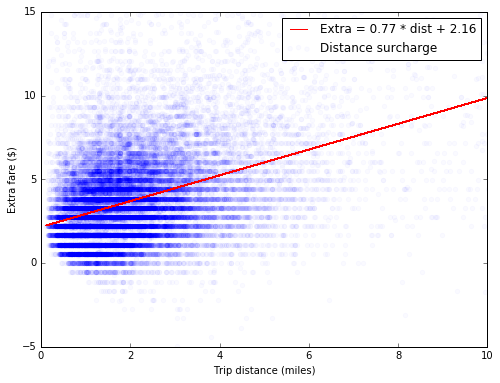

In [12]:
# for convenience, create x, t, extra variables
x, t, extra = nsfo_taxi.column("dist (miles)"), nsfo_taxi.column("duration (min)"), nsfo_taxi.column("extra")

plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .02, label='Distance surcharge')

dist_slope = slope(nsfo_taxi,'dist (miles)','extra')
dist_intercept = intercept(nsfo_taxi,'dist (miles)','extra')
plt.plot(x, predict(x,dist_slope,dist_intercept), color='red',
         label='Extra = %.2f * dist + %.2f'%(dist_slope, dist_intercept))

plt.ylim([-5,15])
plt.xlim([0,10])
plt.xlabel("Trip distance (miles)")
plt.ylabel("Extra fare ($)")
plt.legend()

## Extra Fare vs Trip Duration
In the cell below, we construct a scatter plot of the travel time vs. extra cost (above the base fare). We overlay the best-fit regression line on the plot.

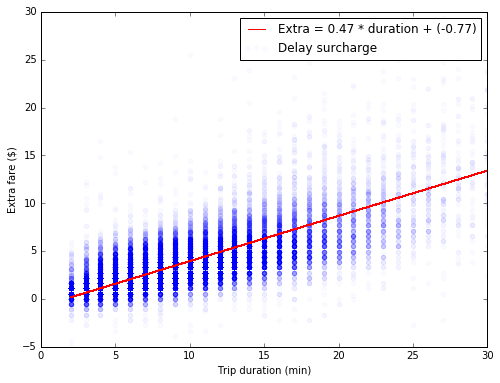

In [13]:
plt.figure(figsize = (8,6))
plt.scatter(t, extra, color='blue', alpha = .02, label='Delay surcharge')

time_slope = slope(nsfo_taxi,'duration (min)','extra')
time_intercept = intercept(nsfo_taxi,'duration (min)','extra')

plt.plot(t, predict(t,time_slope,time_intercept), color='red',
        label='Extra = %.2f * duration + (%.2f)'%(time_slope, time_intercept))
plt.ylim([-5,30])
plt.xlim([0,30])
plt.xlabel("Trip duration (min)")
plt.ylabel("Extra fare ($)")
plt.legend()

## Trip Length or Trip Duration ?
Both length and duration of a trip seem to have an association with extra fares. Longer trips are more expensive. We can characterize this with a correlation coefficient. 
* **Question** From looking at the scatter plots which measure seems to be more indicative of the expected extra cost of a trip?

In [ ]:
# Your answer here:
# The extra fare vs. duration plot seems to be a better fit than extra fare vs.
# distance. The data points are closer to the regression line.

We will use the correation function to compare two variables. In the cell below find 

* the correlation between the "dist (miles)" and "extra".
* the correlation between the "duration (min)" and "extra"

**Question** Based on these results, does trip length or duration seem to be a better predictor of the extra travel fare?

In [14]:
# Your code here:
#Answer key:
dist_extra_correlation = correlation(nsfo_taxi, 'dist (miles)', 'extra')
time_extra_correlation = correlation(nsfo_taxi, 'duration (min)', 'extra')

print('Trip length and extra fare, r=%.3f' % dist_extra_correlation)
print('Trip duration and extra fare, r=%.3f' % time_extra_correlation)

Trip length and extra fare, r=0.327
Trip duration and extra fare, r=0.738


In [15]:
#Your answer here:
# The trip duration and extra fare relationship has a much higher 
# correlation coefficient, so is a better predictor of the extra 
# fare.

# Part 2: Predictions with linear regression
From the previous mini-lab we found that the travel time is a better indicator of the extra fare (fare above the base fare) than travel distance. Let's make a predict_fare_dist(dist, tt) method to estimate the fare for a given trip.

In [16]:
def predict_fare_dist(table, dist):
    # compute parameters of a linear regression for the 'extra', as a function of duration
    dist_slope = slope(table,'dist (miles)','extra')
    dist_intercept = intercept(table,'dist (miles)','extra')
    
    predicted_extra = predict(dist,dist_slope,dist_intercept)
    
    # add base fare and compute predicted 'extra'
    return base_fare(dist) + predicted_extra

def predict_fare_time(table, dist, tt):
    
    # compute parameters of a linear regression for the 'extra', as a function of duration
    tt_slope = slope(table,'duration (min)','extra')
    tt_intercept = intercept(table,'duration (min)','extra')
    
    predicted_extra = predict(tt,tt_slope,tt_intercept)
    
    # add base fare and compute predicted 'extra'
    return base_fare(dist) + predicted_extra

### Using these functions:

In [17]:
d = 12.1
tt = 46.0

print('Base fare for a %.1f miles trip is: $%.1f' % (d, base_fare(d)))
print('Predicted actual fare for a %.1f miles trip is: $%.1f' % (d, predict_fare_dist(nsfo_taxi, d)))
print('Predicted actual fare for a %.1f miles trip that takes %.1f minutes is: $%.1f' 
          % (d, tt, predict_fare_time(nsfo_taxi, d, tt)))

Base fare for a 12.1 miles trip is: $36.0
Predicted actual fare for a 12.1 miles trip is: $47.4
Predicted actual fare for a 12.1 miles trip that takes 46.0 minutes is: $56.9


## Computing predictions for a table
We can write similar functions to predict fares for a whole table. Instead of passing the length and duration arguments, we will pass the whole table_q to the prediction function. It can be the same table that is used to estimate parameters, or a different table containing the trips for which fares are unknown and has to be predicted.

In [18]:
def predict_fare_table_dist(table, table_q):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    dist_slope = slope(table,'dist (miles)','extra')
    dist_intercept = intercept(table,'dist (miles)','extra')
     
    predicted_extra = predict(table_q.column("dist (miles)"),dist_slope,dist_intercept)
    
    # add base fare and compute predicted 'extra'    
    return base_fare(table_q["dist (miles)"]) + predicted_extra

def predict_fare_table_time(table, table_q):
    
    # compute parameters of a linear regression for the 'extra', as a function of duration
    tt_slope = slope(table,'duration (min)','extra')
    tt_intercept = intercept(table,'duration (min)','extra')
    
    predicted_extra = predict(table_q.column("duration (min)"),tt_slope,tt_intercept)
    
    # add base fare and compute predicted 'extra'    
    return base_fare(table_q["dist (miles)"]) + predicted_extra

## Does it work? 

Let's see if our method produces accurate predictions. We are going to give it only a part of the trips (for example, first 10000) to estimate parameters, and then see if we can predict the fares for the rest of the dataset.

We will call these subset training and testing tables. 

In [19]:
# training and testing data tables
train_table = nsfo_taxi.where(nsfo_taxi["id"]<10000)
test_table = nsfo_taxi.where(nsfo_taxi["id"]>10000)

# compute predictions
pred = predict_fare_table_dist(train_table, test_table)
pred_time = predict_fare_table_time(train_table, test_table)

### How accurate are our predictions?
We can compare our predictions with the right answers (we know them in this case sinse we partitioned the data ourselves). Let's do it with a *predicted vs observed* scatterplot.

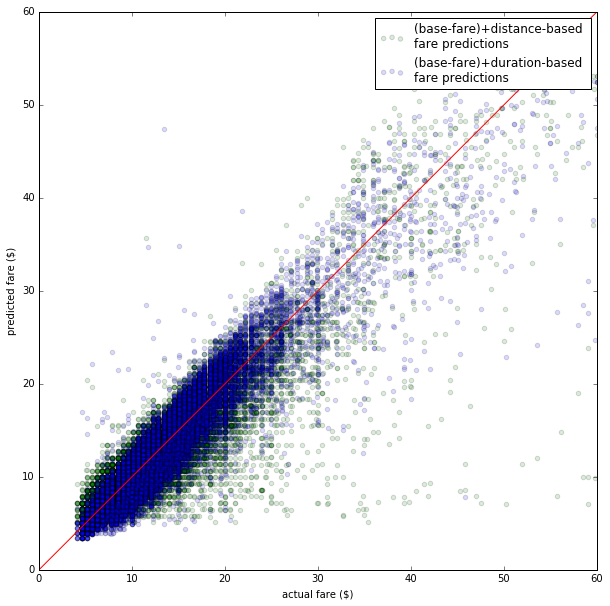

In [27]:
# plot predictions vs known (for both methods)
plt.figure(figsize = (10,10))
plt.scatter( test_table["fare ($)"], pred, c='g', alpha=0.15, 
            label="(base-fare)+distance-based \nfare predictions")
plt.scatter( test_table["fare ($)"], pred_time, c='b', alpha=0.15, 
            label="(base-fare)+duration-based \nfare predictions")
plt.plot([0, 60], [0, 60], 'red')
plt.ylim([0,60])
plt.xlim([0,60])
plt.xlabel('actual fare ($)')
plt.ylabel('predicted fare ($)')
plt.legend()

* **Question 1**: What does the red line represent in the plot above?
* **Question 2**: Which gives better predictions - the distance-based method, or the duration based method? How do you know?


In [28]:
# Your answers here:

### Root Mean Square Error

Let's quantify how much better one method is than the other. We will use an RMSE to characterize how well our predictions match the observed data. 

In [39]:
def RMSE(y,yp):
    
    return np.sqrt(np.sum( (y-yp)*(y-yp) ) / len(y))

print("With distance only:", RMSE(test_table["fare ($)"], pred))
print("With distance & TT:", RMSE(test_table["fare ($)"], pred_time))

With distance only: 3.6279494619
With distance & TT: 2.58885621637


## Wait, but trip duration is not known before the trip is taken...!

Indeed, both scatterplot and RMSE show that knowing trip duration helps a lot in predicting the fares. The problem is that it is not known before the trip is taken. One could use a routing service to get an estimated trip duration from a trustful third party.

Or... we can predict it from data too! 

Travel time within city limits will depends on the day of the week and the time of the day. Therefore our predictions will be made for each given time of day / day of week. 

In [29]:
# this function returns the parameters
def get_TT_params(table, day, hour):
    
    tb = table.where(table['day of week']==day)
    tb = tb.where(tb['start hour']==hour)
    
    dist_slope = slope(tb,'dist (miles)','duration (min)')
    dist_intercept = intercept(tb,'dist (miles)','duration (min)')
     
    return dist_slope, dist_intercept

# this fucntion returns the predictions
def predict_TT(table, dist, day, hour):
    
    tb = table.where(table['day of week']==day)
    tb = tb.where(tb['start hour']==hour)
    
    dist_slope = slope(tb,'dist (miles)','duration (min)')
    dist_intercept = intercept(tb,'dist (miles)','duration (min)')
     
    return dist_slope*dist+dist_intercept

## Explore model parameters.
Let us explore if this approch makes sense. We can look if model parameters vary throught the day/week. We are going to loop over days/hours within a week, estimate model paramaters and save them in a form of the average speed [mph].

In [64]:
inverse_slopes = [] # we will store results here
intercepts = []

ind = np.arange(7*24)

hours = np.arange(0,24) # 24 hours
wdays = np.arange(0,7) # 7 days

#Your task
# 1. do an outer loop through the weekdays
# 2.  do an inner loop through the hours
# 3.   find the linear relationship between travel time and distance 
#      for the given weekday and hour. You can use the get_TT_parameters
#      method above to help you out! 
#      Append 60/a to the inverse_slopes list.
#      Append b to the intercepts list

#Your code here:
# Solutions:
for wday in wdays:
    for h in hours: 
    
        a, b = get_TT_params(nsfo_taxi, wday, h)
        
        inverse_slopes.append( 60/(a)) 
        intercepts.append(b)

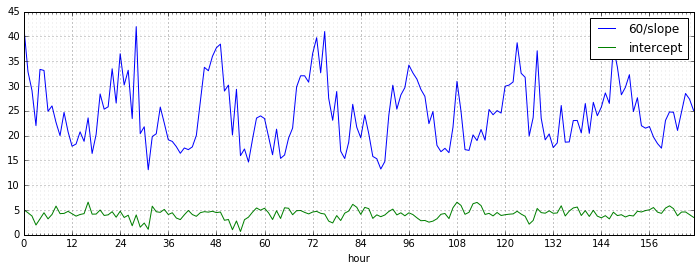

In [67]:
fig = plt.figure(figsize=(12,4))                                                               
ax = fig.add_subplot(1,1,1)  

# major ticks every 12, minor ticks every 1 hour                                      
major_ticks = np.arange(0, 24*7, 12)                                              
minor_ticks = np.arange(0, 24*7, 1)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.75) 

ax.set_xlabel('hour')
# ax.set_ylabel('average travel speed')

ax.plot(ind, inverse_slopes, label='60/slope')
ax.plot(ind, intercepts, label='intercept')
ax.legend()

** Question**: How can we interpret the inverse_slopes parameters and intercept parameters?

In [63]:
# Your answer here


### Predictions assuming trip duration is known
(same as above)

In [32]:
d = 12.1
tt = 46.0

print('Base fare for a %.1f miles trip is: $%.1f' % (d, base_fare(d)))
print('Predicted actual fare for a %.1f miles trip is: $%.1f' % (d, predict_fare_dist(nsfo_taxi, d)))
print('Predicted actual fare for a %.1f miles trip that takes %.1f minutes is: $%.1f' 
          % (d, tt, predict_fare_time(nsfo_taxi, d, tt)))

Base fare for a 12.1 miles trip is: $36.0
Predicted actual fare for a 12.1 miles trip is: $47.4
Predicted actual fare for a 12.1 miles trip that takes 46.0 minutes is: $56.9


### Predictions of fare based on predicted trip duration

First, we predict trip duration for a given length, if it start on a given day at a given hour.

Then, we use this travel time to predict the fare.

In [33]:
day = 1
hour = 9
d = 12.1

TT = predict_TT(nsfo_taxi, d, day, hour)
print('Precited travel time for a %.1f miles trip on day %d at hour %d is: %.1f minutes.' % (d, day, hour, TT))

print('Predicted actual fare for this trip is: $%.1f' 
          % predict_fare_time(nsfo_taxi, d, TT))

Precited travel time for a 12.1 miles trip on day 1 at hour 9 is: 40.3 minutes.
Predicted actual fare for this trip is: $54.2


## Do predicted fares vary throughout a week?

Let's check, for a trip of given length.

In [34]:
dist = 12.0 

dfares = [] # we will store results here

ind = np.arange(7*24)

hours = np.arange(0,24) # 24 hours
wdays = np.arange(0,7) # 7 days

for wday in wdays:
    for h in hours: 
    
        TT = predict_TT(nsfo_taxi, dist, wday, h)
        ff = predict_fare_time(nsfo_taxi, dist, TT)
        
        dfares.append( ff ) 

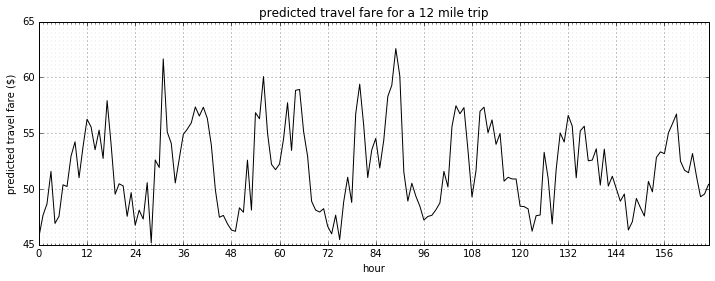

In [35]:
fig = plt.figure(figsize=(12,4))                                                               
ax = fig.add_subplot(1,1,1)  

# major ticks every 12, minor ticks every 1 hour                                      
major_ticks = np.arange(0, 24*7, 12)                                              
minor_ticks = np.arange(0, 24*7, 1)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.75) 

ax.set_xlabel('hour')
ax.set_ylabel('predicted travel fare ($)')
ax.set_title('predicted travel fare for a 12 mile trip')

ax.plot(ind, dfares, 'k')

# How accurate is our final method?

Minilab TASK: Apply the prediciton method to the test table and compare the RMSE values with the ones above. 

In [36]:
# Predict tt for the whole table:

# this takes a while to run!
predicted_tt = nsfo_taxi.apply(lambda dist, day, hour: predict_TT(nsfo_taxi, dist, day, hour), 
                               ['dist (miles)', 'day of week', 'start hour'])

#add predicted tt to the table:
nsfo_taxi = nsfo_taxi.with_column('predicted_tt', predicted_tt)

# create a method to predict using the predicted tt column
def predict_fare_table_predictedtt(table, table_q):
    # compute parameters of a linear regression for the 'extra', as a function of duration
    tt_slope = slope(table,'duration (min)','extra')
    tt_intercept = intercept(table,'duration (min)','extra')
    
    predicted_extra = predict(table_q.column("predicted_tt"),tt_slope,tt_intercept)
    # add base fare and compute predicted 'extra'    
    return base_fare(table_q["dist (miles)"]) + predicted_extra

#separate train and test data:
train_table = nsfo_taxi.where(nsfo_taxi["id"]<10000)
test_table = nsfo_taxi.where(nsfo_taxi["id"]>10000)

# compute predictions
pred = predict_fare_table_dist(train_table, test_table)
pred_predtt = predict_fare_table_predictedtt(train_table, test_table)

In [65]:
nsfo_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),duration (min),start hour,date,day of week,extra,predicted_tt
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084,9,0,2012-09-01,5,5.3,8.01113
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224,8,0,2012-09-01,5,1.1,8.85522
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348,4,0,2012-09-01,5,4.95,5.00361
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807,4,1,2012-09-01,5,1.65,6.22041
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851,12,1,2012-09-01,5,6.6,6.06693
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315,2,2,2012-09-01,5,1.1,5.02147
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312,4,4,2012-09-01,5,1.65,5.44389
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807,6,1,2012-09-01,5,2.75,7.33347
11,9/1/12 1:46,9/1/12 1:56,11.75,1,-122.393,37.7789,-122.411,37.7924,109,28,1.77117,10,1,2012-09-01,5,4.4,7.67754
12,9/1/12 0:24,9/1/12 0:31,8.45,1,-122.41,37.7879,-122.405,37.798,7,37,1.42192,7,0,2012-09-01,5,1.65,6.8916


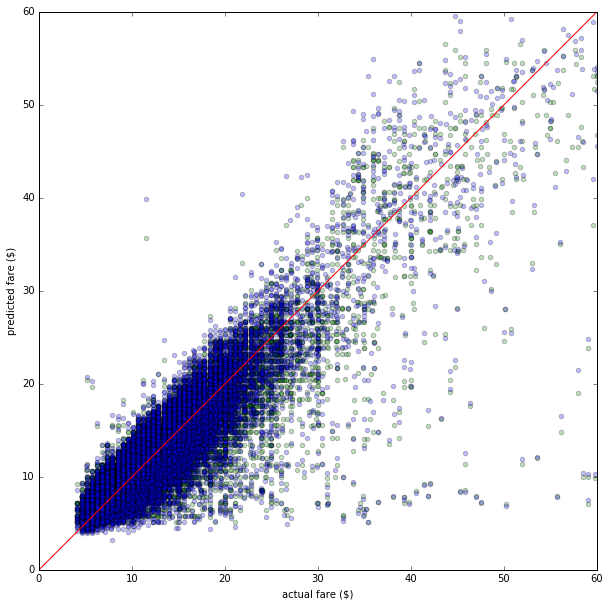

In [37]:
# plot predictions vs known (for both methods)
plt.figure(figsize = (10,10))
plt.scatter( test_table["fare ($)"], pred, c='g', alpha=0.25)
plt.scatter( test_table["fare ($)"], pred_predtt, c='b', alpha=0.25)
plt.plot([0, 60], [0, 60], 'red')
plt.ylim([0,60])
plt.xlim([0,60])
plt.xlabel('actual fare ($)')
plt.ylabel('predicted fare ($)')

In [40]:
print("With distance only:", RMSE(test_table["fare ($)"], pred))
print("With distance & TT:", RMSE(test_table["fare ($)"], pred_time))
print("With distance & predicted TT:", RMSE(test_table["fare ($)"], pred_predtt))

With distance only: 3.6279494619
With distance & TT: 2.58885621637
With distance & predicted TT: 3.59182150103
